In [1]:
from preproceso import get_processed_data
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit,KFold
import random
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from preproceso import RELEVANT_COUNTRIES, get_processed_data
from utils_eval import evaluate_predicted_df, plot_roc, get_metric_and_best_threshold_from_roc_curve
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from preproceso import periodo_dict
import matplotlib.pyplot as plt


# Obtener datos ya procesados

El proceso de datos se contiene en una sola función para facilitar su uso en diversas áreas. El detalle de los preprocesos está en la función get_processed_data.


In [2]:
df,company_dict=get_processed_data()

/home/aferral/PycharmProjects/desafio_globant/preproceso.py:61: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(rt)


# 1. == ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto? ==




De revisar los datos hay varias cosas a destacar

## -- Los datos son únicamente de salidas del aeropuerto de santiago --

Todos los vuelos son del mismo origen siendo este el aeropuerto de Santiago (Comodoro Arturo Merino Benitez).

### De esto se tiene que :

* Se quitó esa columna ya que en todos los puntos son el mismo valor.
* Hay que tener cuidado con intentar generalizar el modelo o las conclusiones fuera de este aeropuerto. Un modelo entrenado sobre estos datos puede ser inadecuado de aplicar a cualquier aeropuerto en otro lugar del mundo.


## -- Temporalidad de los datos --

Los datos son vuelos entre 01-01-2017 a 01-01-2018 por lo tanto contamos con un año de datos.

Respecto a la cantidad de vuelos se revisó los vuelos por semana para tener una idea de la distribución.

Si se cuenta por semana se observa que generalmente la cantidad de vuelos crecen entre 16%  = (1400-1200) / (1200) desde la temporada baja a la alta. También hay claros peek al inicio y la mitad del año.


### De esto se tiene que :

* Hay claros peeks de demanda .
* Como se tiene un año de datos va ser difícil generalizar los patrones estacionales. Es decir ¿El comportamiento en junio de 2017 es generalizable a otros años ? Dado los datos actuales no es posible determinarlo.



<AxesSubplot: xlabel='Fecha-I'>

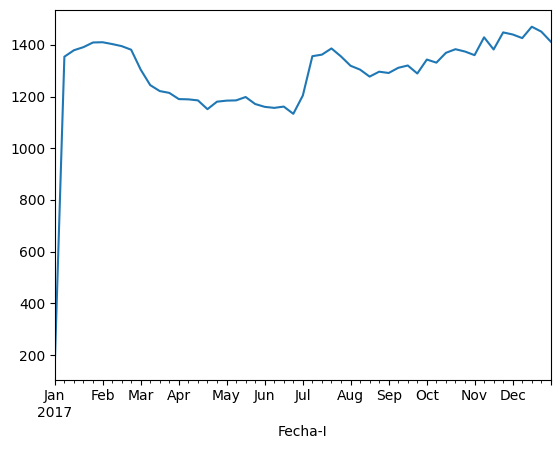

In [3]:
df.groupby(pd.Grouper(key='Fecha-I',freq='W'))['Vlo-I'].count().plot()

# -- Temporada alta --
Revisando la definición del problema se define temporada alta como
* Entre 15 dic a 3 mar
* Entre 15 jul a 31 jul
* Entre 11 sept a 30 sep

En los datos de 2017 calza en dic-marzo, pero para julio el peek parece estar en la primera quincena y para el caso de septiembre el peek parece ocurrir en octubre.

También sobre la temporada alta esta concentra el 33% del total de vuelos.


### De esto se tiene que :

* La temporada alta del 2017 no calza del todo con la especificación dada.


<AxesSubplot: >

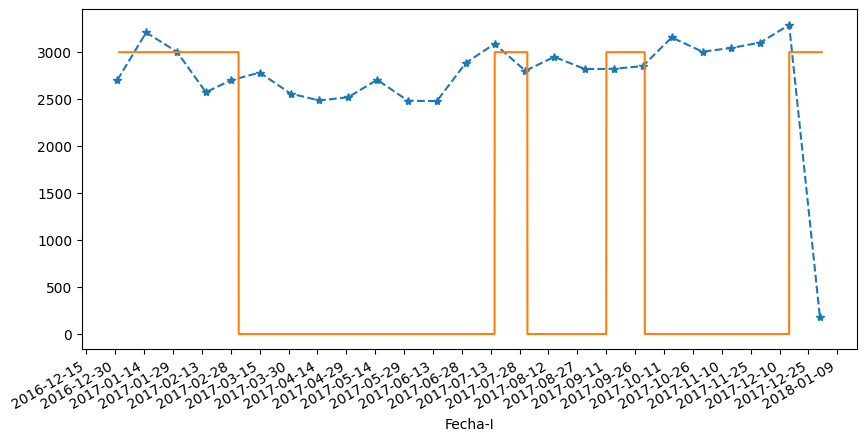

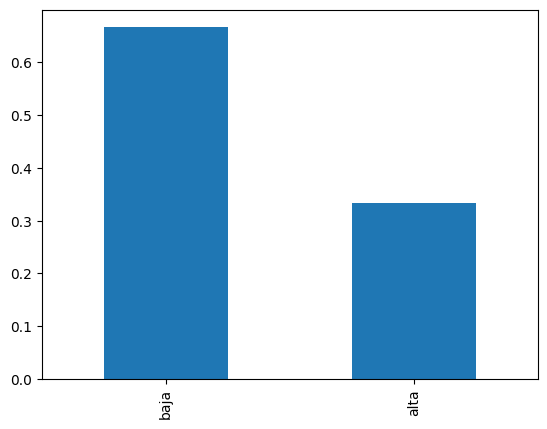

In [4]:

#Si bien el peek de dic-marzo , julio es claro. El otro peek parece ser octubre y no septiembre como sale en temporada alta
ax = df.groupby(pd.Grouper(freq='SM', key='Fecha-I'))['Fecha-I'].count().plot(style='*--',
                                                                              figsize=(10,5))
plt.figure()
ax=(df.set_index('Fecha-I')['temporada_alta']*3000).plot(ax=ax, x='Fecha-I', y='temporada_alta')
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=15, tz=None))


df['temporada_alta'].value_counts(normalize=True).rename({0:'baja',1:'alta'}).plot.bar()

# -- Vuelos por empresa --

Vuelos muy concentrados entre GRUPO LATAM y sky (80 % de los vuelos)


### De esto se tiene que :

* Hay que tener cuidado con ajustar variables como promedios a cada aerolínea, ciertas aerolíneas tienen muy pocos datos para obtener un valor significativo.


<AxesSubplot: >

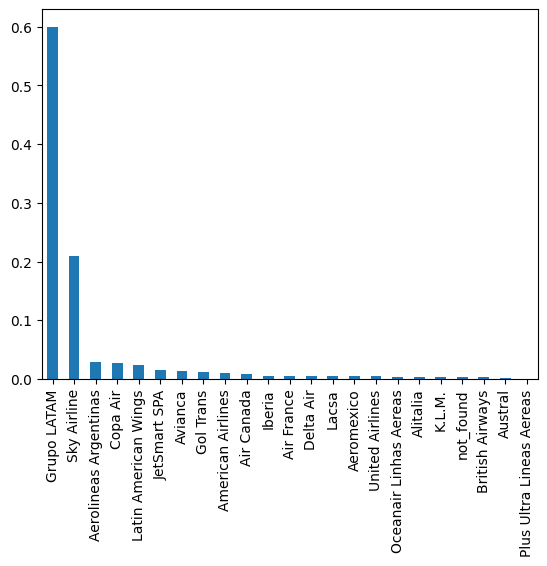

In [5]:
df['Emp-O'].value_counts(normalize=True)
df['emp']=[company_dict.get(x,'not_found') for x in df['Emp-O'].values.tolist()]
df['emp'].value_counts(normalize=True).plot.bar()

# -- Vuelos nacionales vs internacionales --

Ligeramente más vuelos nacionales 54% vs 45%

Y también siguen un patrón de demanda similar en el año. Observar el gráfico y ver que la proporción de vuelos se mantiene más o menos estable.

### De esto se tiene que :

* En términos de demanda los vuelos nacionales e internacionales siguen el mismo comportamiento en el año. Con esto me refiero a la forma de la curva, en términos de cantidad los vuelos nacionales son mayores.


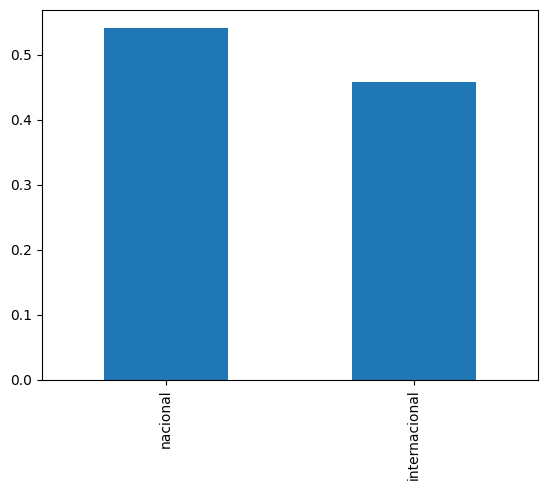

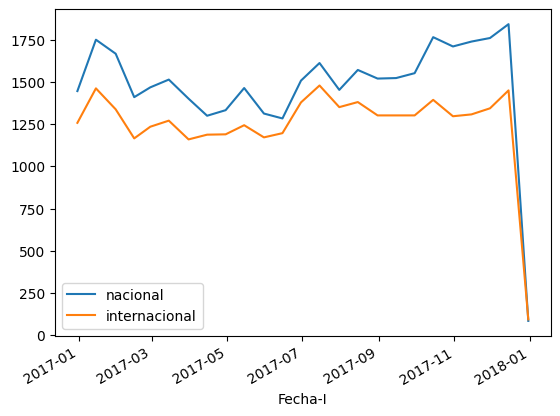

In [6]:
name_dict={0:'nacional',1:'internacional'}
df['TIPOVUELO'].value_counts(normalize=True).rename(name_dict).plot.bar()

key_to_use='TIPOVUELO'
res=df.groupby([pd.Grouper(key='Fecha-I',freq='SM'),key_to_use])['Vlo-I'].count().reset_index()
ax=None
for key,df_key in res.groupby(key_to_use):
    ax=df_key.plot(x='Fecha-I',y='Vlo-I',ax=ax,label=name_dict[key])
plt.show()

In [7]:
key_to_use='TIPOVUELO'
res=df.groupby([pd.Grouper(key='Fecha-I',freq='M'),key_to_use])['Vlo-I'].count().reset_index()
r1=df[df[key_to_use] == 0].groupby([pd.Grouper(key='Fecha-I',freq='M'),key_to_use])['Vlo-I'].count().reset_index()
r2=df[df[key_to_use] == 1].groupby([pd.Grouper(key='Fecha-I',freq='M'),key_to_use])['Vlo-I'].count().reset_index()

z=r1.merge(r2,on='Fecha-I',how='left')
z['ratio']= z['Vlo-I_y'] / z['Vlo-I_x']
z

,Fecha-I,TIPOVUELO_x,Vlo-I_x,TIPOVUELO_y,Vlo-I_y,ratio
0,2017-01-31,0,3303,1,2805,0.849228
1,2017-02-28,0,3062,1,2499,0.816133
2,2017-03-31,0,2986,1,2494,0.835231
3,2017-04-30,0,2666,1,2355,0.883346
4,2017-05-31,0,2812,1,2427,0.863087
5,2017-06-30,0,2608,1,2374,0.910276
6,2017-07-31,0,3127,1,2864,0.915894
7,2017-08-31,0,3025,1,2719,0.898843
8,2017-09-30,0,3005,1,2605,0.866889
9,2017-10-31,0,3345,1,2687,0.803288


# -- Sobre los cambios en planificación --

Según los datos hay diversos cambios respecto a las variables I (planeada) y O (Operada). Se distinguen 3 cambios

### De esto se tiene que :

* Los cambios de vuelo y los cambios de destino no son variables útiles. Ya que incluso si fueran predictores perfectos solo son aplicables a un conjunto infinito de puntos.
* El cambio de empresa es común por lo tanto puede ser una variable a considerar.


In [8]:
n_global=df.shape[0]

# pocas veces cambian de vuelo el numero
n_casos=(df['Vlo-O'] != df['Vlo-I']).sum()
print("Casos: {0} de {1} | {2}".format(n_casos,n_global,n_casos*1.0/n_global))

# Es bastante comun cambiar de empresa (notar que en la mayoria no cambia numeros de vuelo)
n_casos=(df['Emp-O'] != df['Emp-I']).sum()
print("Casos: {0} de {1} | {2}".format(n_casos,n_global,n_casos*1.0/n_global))


# MUy poco comun cambiar destino
n_casos=(df['Des-I'] != df['Des-O']).sum()
print("Casos: {0} de {1} | {2}".format(n_casos,n_global,n_casos*1.0/n_global))


Casos: 120 de 68206 | 0.0017593760079758379
Casos: 18669 de 68206 | 0.273714922440841
Casos: 28 de 68206 | 0.0004105210685276955


# -- Sobre atrasos en general --

* El atraso en minutos es generalmente de 4 minutos. Hay que llegar al percentil 90 para tener un atraso de 15 minutos (eventos raros)

* Aproximadamente el 20% de los vuelos tiene atraso
* Hay claros peeks de atraso que parecen coincidir con peeks de demanda



In [9]:
print(df['dif_min'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
df['atraso_15'].value_counts(normalize=True)

0.1    -4.0
0.2    -2.0
0.3     0.0
0.4     2.0
0.5     4.0
0.6     6.0
0.7     9.0
0.8    14.0
0.9    26.0
Name: dif_min, dtype: float64


0    0.81506
1    0.18494
Name: atraso_15, dtype: float64

<AxesSubplot: xlabel='Fecha-I'>

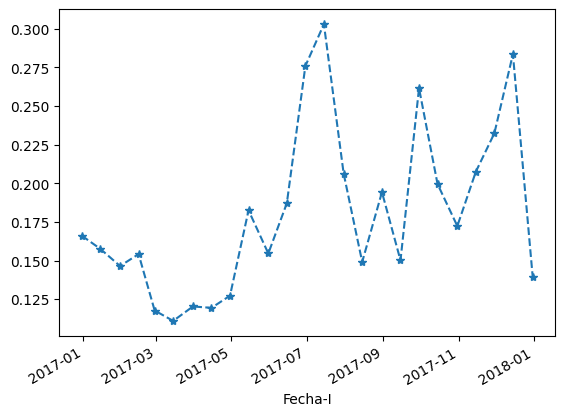

In [10]:
#* el rate de atraso tambien crece en temporada alta
#es entonces importante la demanda del aeropuerto

df.groupby(pd.Grouper(freq='SM',key='Fecha-I'))['atraso_15'].mean().plot(style='*--')


### De esto se tiene que :

* Hay que tener cuidado con el desbalance de clases la clase negativa = "no atraso" vs clase positiva = "atraso" está en relación 1 es a 4. Esto coloca ciertas consideraciones sobre el entrenamiento.

* Un atraso de 15 minutos es considerable ya que está sobre el percentil 80.

* La demanda de vuelos parece influir bastante en atraso ya que cambia de 12% a 30 % según peeks


# -- Dias de vuelo y periodo_dia --

* Los días de vuelo más comunes son viernes y jueves el menos común sabado
* Los vuelos están más o menos equitativos en mañana y día. La noche tiene un poco menos


### De esto se tiene que :

* Hay cierto comportamiento distintivo en la semana el cual tiene peek y valles. Esto da la intuición de usar alguna clase de variable para diferenciar diversos días (ejemplo one hot encoding).
* Lo mismo con el periodo del día.


4    0.150896
3    0.150295
0    0.148535
6    0.143624
2    0.142539
1    0.141659
5    0.122453
Name: DIANOM, dtype: float64


<AxesSubplot: xlabel='DIANOM'>

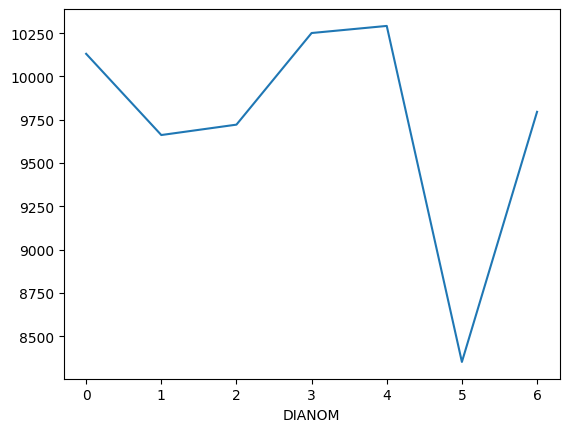

In [11]:
print(df['DIANOM'].value_counts(normalize=True))
df.groupby('DIANOM')['Emp-I'].count().plot()

In [12]:
df['periodo_dia'].value_counts(normalize=True)

1    0.373955
0    0.371698
2    0.254347
Name: periodo_dia, dtype: float64

# Otras cosas

In [13]:
#* Esta mal definida el label de OPERA. Opera es realmente el label de la empresa del vuelo programado (Emp-I)

aux=pd.read_csv('dataset_SCL.csv')
aux[aux['Emp-O'] == 'AUT'][['Emp-I','Emp-O','OPERA']].drop_duplicates()


/tmp/ipykernel_14109/2520571742.py:3: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  aux=pd.read_csv('dataset_SCL.csv')


,Emp-I,Emp-O,OPERA
343,AUT,AUT,Austral
11991,ARG,AUT,Aerolineas Argentinas


# 2. == Generar columnas adicionales ==

El codigo para generar las columnas esta comentado en get_processed_data. 

In [14]:
%psource get_processed_data


In [15]:
# generar archivo con variables solicitadas
df_export=df[['Fecha-I','Fecha-O','temporada_alta','dif_min','atraso_15','periodo_dia']]
df_export['periodo_dia']=[periodo_dict[x] for x in df['periodo_dia'].values.tolist()]
df_export.to_csv('synthetic_features.csv',index=False)

/tmp/ipykernel_14109/2741381162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['periodo_dia']=[periodo_dict[x] for x in df['periodo_dia'].values.tolist()]


# 3. == Como se distribuye la tasa de atraso dado diversas variables ==

# Efecto del aeropuerto destino
Primero se revisa si dependiendo del aeropuerto destino como varía el atraso.

* Se quitan el destino con muy pocos datos ya que pueden ser promedios muy ruidosos.
* Aun después de quitar estos valores hay clara diferencia. La tasa de atraso general es del 20% hay aeropuerto con tasas del 14 % (ver percentil 30 hacia atrás) y una gran cantidad con tasas arriba de 25 % (ver percentil 70 en adelante).

De esto se tiene que el destino tiene importancia considerable en el atraso.




0.0    0.050746
0.1    0.080498
0.2    0.132825
0.3    0.147712
0.4    0.156019
0.5    0.185185
0.6    0.195073
0.7    0.241134
0.8    0.260635
0.9    0.294438
Name: m, dtype: float64


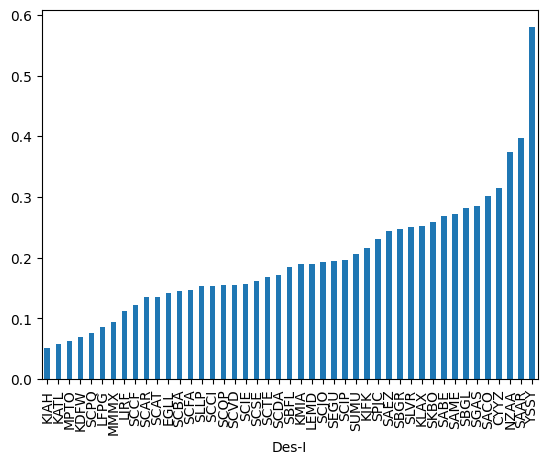

In [16]:
# efecto del destino en atraso 
rr = df.groupby('Des-I').agg(n=('atraso_15', 'count'), m=('atraso_15', 'mean'))
rr['enough']=rr['n'] > 100
xt=rr[rr.enough]
xt.sort_values('m')['m'].plot.bar()
print(xt['m'].quantile([0.1 * i for i in range(10)]))

# Efecto del país destino

Dado que consiguió el país destino se puede hacer el mismo análisis anterior. Da resultados similares y los valores se mueven en rangos similares.

También como son menos valores es posible crear one hot encoding (si son muchos valores la dimensionalidad crece mucho y dificulta entrenamiento de modelos).




0.0    0.062703
0.1    0.099053
0.2    0.129666
0.3    0.148283
0.4    0.190307
0.5    0.197647
0.6    0.225485
0.7    0.257055
0.8    0.273066
0.9    0.326382
Name: m, dtype: float64


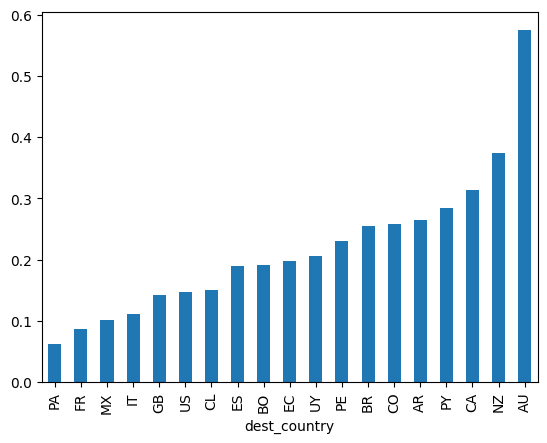

In [17]:
# efecto del pais destino en atraso 
rr = df.groupby('dest_country').agg(n=('atraso_15', 'count'), m=('atraso_15', 'mean'))
rr['enough']=rr['n'] > 100
xt=rr[rr.enough]
xt.sort_values('m')['m'].plot.bar()
print(xt['m'].quantile([0.1 * i for i in range(10)]))

# Efecto de distancia

Practicamente nada. La distribucion de distancia de "atraso" es practicamente la misma de "sin atraso"

<AxesSubplot: >

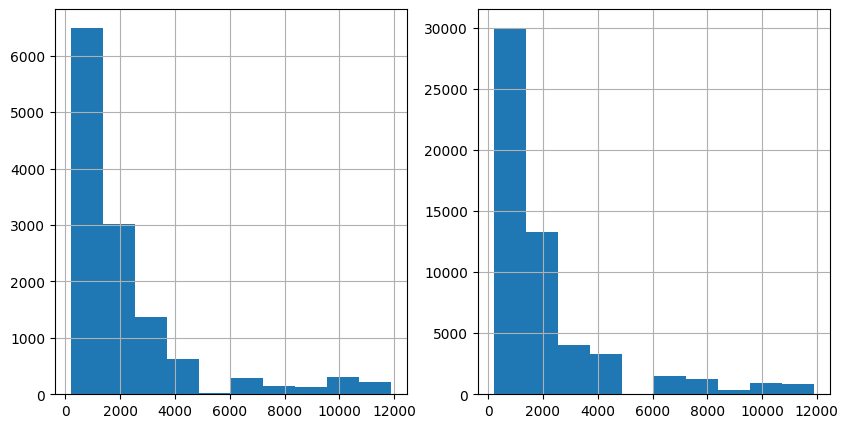

In [18]:
sel=df[df.atraso_15 == 1]
f,axs=plt.subplots(1,2,figsize=(10,5))
sel['dest_dist'].hist(ax=axs[0])

sel=df[df.atraso_15 == 0]
sel['dest_dist'].hist(ax=axs[1])


# Efecto del atraso dado empresa

Dado la empresa los efectos son hasta más extremos que con los destinos. Se destaca un percentil 90 de 40% de atraso.

Esto puede indicar que la empresa es una variable bastante importante para predecir los retrasos.




In [19]:
# efecto de empresa en atraso efecto igual importante. del percentil 0.7 es bastante alto
rr = df.groupby('Emp-I').agg(n=('atraso_15', 'count'), m=('atraso_15', 'mean'))
rr['enought']=rr['n'] > 100
print(rr[rr.enought]['m'].quantile([0.1 * i for i in range(10)]))

0.0    0.028490
0.1    0.059064
0.2    0.070630
0.3    0.088493
0.4    0.123767
0.5    0.162847
0.6    0.178456
0.7    0.251112
0.8    0.279051
0.9    0.402698
Name: m, dtype: float64


# Efecto del periodo del dia

Es menor aunque el la mañana hay poco atraso.

In [20]:
# efecto de tiempo del dia en atraso
# no mucho, pero en la manana tiene de ser menor atraso
df[['periodo_dia', 'atraso_15']].groupby('periodo_dia').agg(n=('atraso_15', 'count'), m=('atraso_15', 'mean'))

,n,m
periodo_dia,,
0,25352,0.160066
1,25506,0.199404
2,17348,0.200023


# Efecto del tipo de viaje

Es importante ya que hay clara tendencia a que vuelos nacionales bajo atraso y que vuelos internacionales tienden a retrasarse.




In [21]:
# efecto del tipo de viaje en atraso. Efectoi mportante
rr = df.groupby('TIPOVUELO').agg(n=('atraso_15', 'count'), m=('atraso_15', 'mean'))
print(rr)

               n         m
TIPOVUELO                 
0          36966  0.150571
1          31240  0.225608


# Efecto del mes en atraso

Esto ya se grafico en el atraso vs la fecha. Se tiene que en periodos de mayor demanda crece el atraso.

In [22]:
# efecto del mes en atraso. HAy importancia a periodos de alta actividad veer como sube atraso
rr = df.groupby(pd.Grouper(freq='M', key='Fecha-I')).agg(n=('atraso_15', 'count'), m=('atraso_15', 'mean'))
print(rr)

               n         m
Fecha-I                   
2017-01-31  6108  0.160282
2017-02-28  5561  0.151591
2017-03-31  5480  0.114781
2017-04-30  5021  0.116710
2017-05-31  5239  0.157664
2017-06-30  4982  0.171016
2017-07-31  5991  0.293440
2017-08-31  5744  0.173398
2017-09-30  5610  0.172371
2017-10-31  6032  0.225962
2017-11-30  6081  0.197336
2017-12-31  6357  0.254051


# Efecto dia de la semana

Bastante ligero el efecto. Sigue que mayor efecto en dia de mayor demanda

0.0    0.161086
0.1    0.162351
0.2    0.164379
0.3    0.167932
0.4    0.169810
0.5    0.170850
0.6    0.188035
0.7    0.200025
0.8    0.201620
0.9    0.210098
Name: m, dtype: float64


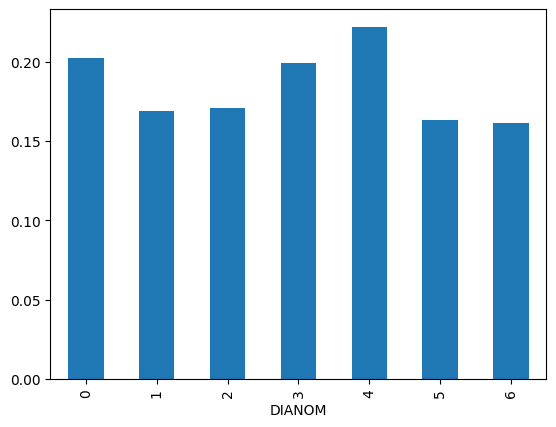

In [23]:
# efecto del dia de la semana. a mayor cantidad de gente sube algo el % de atraso.
rr = df.groupby('DIANOM').agg(n=('atraso_15', 'count'), m=('atraso_15', 'mean'))
rr['enough']=rr['n'] > 100
xt=rr[rr.enough]
xt['m'].plot.bar()
print(xt['m'].quantile([0.1 * i for i in range(10)]))

# Efecto temporada alta

El efecto es bastante poco. Puede deberse a que la temporada alta como variable no calza con la verdadera temporada alta del 2017 (ver graficos en seccion 1)

In [24]:
# efecto de temporada. Ligereamente mas alta segun temporada alta o no
rr = df.groupby('temporada_alta').agg(n=('atraso_15', 'count'), m=('atraso_15', 'mean'))
print(rr)

                    n        m
temporada_alta                
0               45444  0.17921
1               22762  0.19638


Dado todo lo anterior parece ser que lo importante es

* Efecto demanda > Efecto empresa > Efecto aeropuerto / pais destino > Efecto dia / período dia




# -- Variables agregadas --

Con eso en mente se agregaron estas variables al modelo.  (mayores detalles de cálculo en código)

* rolling_emp_carga : Nivel de carga de empresa dado los últimos 30 días (cantidad de vuelos).

* rolling_dest_carga : Nivel de carga de aeropuerto destino dado los últimos 30 días (cantidad de vuelos).

* x0,x1,x2 : Variables que indican días modulados por semana, quincena y bloques de 4 meses. La idea es darle pistas de estacionalidad al modelo. Esto busca codificar la demanda en variables.

* emp_confianza: Por empresa el atraso promedio que tiene. Si son muy pocos datos se coloca 20%.

* aeropuerto_confianza : Por aeropuerto colocar promedio de atraso. Si son muy pocos datos se coloca 20%.


* Calidad dia: Se ordenan de 0 a 7 días según demanda y se normaliza a intervalo 0-1.
* Calidad year_dia: Se ordenan de 0 a 365 los días según demanda y se normaliza a intervalo 0-1.

* One hot encoding de día: Ya que son pocos días se agrega el one hot encoding de los días.

* One hot encoding de países: Ya que son pocos días se agrega el one hot encoding de los dias.


# -- Variables fuera --

* Los cambios no de empresa son muy pocos para ser importantes.
* La distancia al aeropuerto destino. La distribución es idéntica por lo que no es distinguible
* La temporada alta tiene poco efecto y no calza con la demanda real.





# 4. == Entrenar modelos para obtener probabilidad de atraso ==


# Como separar entrenamiento y validación

Dado que los datos son series de tiempo hay que tener cuidado en cómo separar entrenamiento y validación.
Los datos no son independientes entre sí por lo que de separar de forma aleatoria el modelo podría tener cierta ventaja o ser la evaluación muy poco realista. Los puntos cercanos en el tiempo contienen mucha información común por lo tanto dan mucha información sobre el set de validación lo que implicaría sobre ajustar el modelo. También se puede pensar como que en la realidad el modelo no va tener puntos de comparación tan cercanos en el tiempo al estar en operación.

Dado eso se utiliza los primeros X meses como entrenamiento y el resto como test.

Esto lamentablemente dificulta encontrar patrones estacionales (ya que hay ciertos meses que no aparecen en entrenamiento)




In [25]:
"""
https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/
"""
tscv = TimeSeriesSplit(n_splits=3)


# Baseline modelo aleatorio

Es importante tener un modelo de prueba para tener una idea de las métricas. De nada sirve obtener métricas sin conocer que tan buenas son en relación a un modelo simple.

En este caso el modelo más simple e interesante es un modelo que genere de forma aleatoria si se retraso o no. Pero con una probabilidad igual al atraso en el general de los datos. Como solo el 20% de los vuelos tienen atraso el modelo genera solo el 20% de las veces label atraso.

El resto de las métricas se detalla más abajo, pero de momento es importante que logra 20% de precisión en atraso y 20 % recall con 69% de exactitud en el general.


In [3]:
# evaluacion de modelo random para tener commparativa (no se usa train-test split 
# ya que el modelo es literalmente ignorante de los datos)
df['y_score']=[random.random() for x in df['id'].values.tolist()]
df['y_pred']=df['y_score']>0.8
evaluate_predicted_df(df,'random_model')
df.drop(['y_score','y_pred'],axis=1);

=========== model: random_model ==============
              precision    recall  f1-score   support

         oka       0.82      0.80      0.81     55592
      atraso       0.19      0.20      0.19     12614

    accuracy                           0.69     68206
   macro avg       0.50      0.50      0.50     68206
weighted avg       0.70      0.69      0.69     68206

ROC area 0.4991589668121109


# Codigo de entrenamiento y evaluación

Dado que el código de entrenamiento y evaluación deben ejecutarse a la vez voy a explicar primero la parte del entrenamiento y en la pregunta siguiente la parte de la evaluación y las métricas.

En términos generales se ejecutan varios entrenamientos (al estilo k folds) para tener una robusta estimación de las métricas en validación. Como se mencionó se va usar los primeros X meses de entrenamiento el resto para validación. En este caso se hacen 3 folds con cantidades cada vez mayores de meses de entrenamiento.

Ej: (puede no ser exactamente con estos meses, pero esta es la idea)

* fold 1 : entrenamiento = [enero,febrero,marzo]  validación = [abril en adelante]
* fold 2 : entrenamiento = [enero,febrero,marzo,abril,mayo]  validación = [junio en adelante]
* fold 3 : entrenamiento = [enero,febrero,marzo,abril,mayo,junio,julio]  validación = [agosto en adelante]

sobre la variables ya se detallo en las secciones anteriores.

El clasificador a utilizar fue un RandomForest. Principalmente los árboles permiten mezclar variables de distintas escalas fácilmente y al ser una colección de muchos pequeños modelos (árboles de decisión) dan las ventajas de un ensemble de forma eficiente.

También en general obtienen métricas más altas que los otros modelos usados (Knn, Logistic Regression)

Sobre las métricas se detalla en la sección siguiente.

Después de iterar 3 veces se sacan promedios de las métricas relevantes (f1 y ROC area) y se obtiene en un solo escalado el performance de modelo. Esto es clave ya que para probar muchos modelos y muchas combinaciones de variables se hace complejo comparar diversas métricas.


In [4]:
from sklearn.model_selection import GridSearchCV
parameters_dict ={
  'LogisticRegression':{'penalty':['l2','l1'],'class_weight':[None,'balanced']},
    'KNeighborsClassifier':{'n_neighbors':[1,2,3,4,5],'weights':['uniform', 'distance']},
    'RandomForestClassifier':{'max_depth':[None,2,3,4,5,6,7]},
} 

In [5]:
FEATURES=[
    'TIPOVUELO',
          'periodo_dia',

          'cambio_empresa',

          'calidad_dia',
          'calidad_year_dia',

    'emp_confianza',
    'aeropuerto_confianza',

          'x0',
          'x1',
          'x2',

          'rolling_emp_carga',
          'rolling_dest_carga',
          ]
FEATURES=FEATURES+['dia_{0}'.format(i) for i in range(7)]
FEATURES=FEATURES+RELEVANT_COUNTRIES

TARGET_COL='atraso_15'

In [6]:
def train_loop(force_th=None,balance_train=False):
    plot=False
    
    global_res=[]
    
    all_models=[
        LogisticRegression(),
        KNeighborsClassifier(n_neighbors=2),
        RandomForestClassifier(max_depth=None, random_state=0),
    ]
    
    df['id']=df.index.values.tolist()
    df_train=df.iloc[0:51155]
    df_test=df.iloc[51155:] # setear DF test desde octubre en adelante

    x_train,y_train=df_train[FEATURES].values,df_train[TARGET_COL].astype(int).values
    x_val,y_val=df_test[FEATURES].values,df_test[TARGET_COL].astype(int).values

    # balancear entrenamiento en cantidades equitativas de positivos y negativos
    folds_to_use=3
    if balance_train:
        """
        Funcionamiento:
        
        - Toma todos los negativos (clase minoritaria)
        - Los reordena aleatoriamente
        - Lo mismo con los positivos
        - Cortar en k pedazos ambas listas
        - Iterar k veces:
        - eleguir 1 fold de validacion y el resto de entrenamiento
        - el fold de validacion se va moviendo
        """
        k_folds=[]
        indexs_to_use=df_train['id'].values.tolist()
        
        pos=df_train[df_train['atraso_15'] == 1]['id']
        neg=df_train[df_train['atraso_15'] == 0]['id']
        out=[]
        step=int(len(neg)*1.0/folds_to_use)

        # shuffle negatives
        neg=neg.sample(frac=1)
        # shuflle positives
        pos=pos.sample(frac=1)
        
        def get_fold(l,pos_of_fold):
            return l[step*pos_of_fold : step*(pos_of_fold+1)].values.tolist()

        for i in range(folds_to_use):
            train_indexs=[]
            val_fold=i
            
            # k-1 folds for train
            for j in range(folds_to_use):
                if j != val_fold:
                    train_indexs = train_indexs + get_fold(neg,val_fold) + get_fold(pos,val_fold)
            # 1 fold validation
            val_indexs= get_fold(neg,val_fold) + get_fold(pos,val_fold)
            
            k_folds.append((train_indexs,val_indexs))

        cv = k_folds
    else:
        cv=folds_to_use
    
    
    for model in all_models:
        model_name=model.__class__.__name__
        print("Training {0}".format(model_name))
        # usar metrica f1 y para los folds los folds equitativos si estan activados
        clf = GridSearchCV(model, parameters_dict[model_name],scoring='f1',cv=cv)
        clf.fit(x_train, y_train)

        df_train['y_score']=clf.predict_proba(x_train)[:,1]

        best_score, TH_TO_USE=get_metric_and_best_threshold_from_roc_curve(y_train, df_train['y_score'].values,
                                                                           calc='f1_pos')
        TH_TO_USE= TH_TO_USE if force_th is None else force_th

        df_test=df_test.assign(y_score=clf.predict_proba(x_val)[:,1])
        df_test=df_test.assign(y_pred=df_test['y_score']>=TH_TO_USE)
        print("Pred distribution: {0}".format(df_test.y_pred.value_counts().to_dict()))
        roc_area,f1_val=evaluate_predicted_df(df_test,model_name,plot=plot)


        global_res.append({'model':model_name,'params':clf.best_params_,'roc_area':roc_area,'f1_mean':f1_val})

    global_res=pd.DataFrame(global_res)
    print(global_res)

In [7]:
import warnings
warnings.filterwarnings("ignore")
train_loop(force_th=None,balance_train=False)

Training LogisticRegression
Threshold 0.4955043641802168 maximizando f1_pos con valor 0.3451486990243734
Pred distribution: {True: 13626, False: 3425}
=========== model: LogisticRegression ==============
              precision    recall  f1-score   support

         oka       0.90      0.23      0.37     13313
      atraso       0.25      0.90      0.39      3738

    accuracy                           0.38     17051
   macro avg       0.57      0.57      0.38     17051
weighted avg       0.75      0.38      0.37     17051

ROC area 0.6178689656622015
Training KNeighborsClassifier
Threshold 0.25 maximizando f1_pos con valor 0.45445140859301847
Pred distribution: {True: 10573, False: 6478}
=========== model: KNeighborsClassifier ==============
              precision    recall  f1-score   support

         oka       0.79      0.39      0.52     13313
      atraso       0.23      0.64      0.34      3738

    accuracy                           0.44     17051
   macro avg       0.51     

In [8]:
import warnings
warnings.filterwarnings("ignore")
train_loop(force_th=None,balance_train=True)

Training LogisticRegression
Threshold 0.17322207640484538 maximizando f1_pos con valor 0.345740773631972
Pred distribution: {True: 13195, False: 3856}
=========== model: LogisticRegression ==============
              precision    recall  f1-score   support

         oka       0.89      0.26      0.40     13313
      atraso       0.25      0.88      0.39      3738

    accuracy                           0.39     17051
   macro avg       0.57      0.57      0.39     17051
weighted avg       0.75      0.39      0.40     17051

ROC area 0.6154726045501894
Training KNeighborsClassifier
Threshold 0.33332913743323533 maximizando f1_pos con valor 0.561122032089217
Pred distribution: {False: 12335, True: 4716}
=========== model: KNeighborsClassifier ==============
              precision    recall  f1-score   support

         oka       0.80      0.74      0.77     13313
      atraso       0.26      0.33      0.29      3738

    accuracy                           0.65     17051
   macro avg   

# 5. Evaluar modelo

Sobre la evaluación del modelo primero fue necesario elegir una métrica a optimizar.

Para esto hay que tener alguna idea de que problema de fondo se busca resolver. En este caso no hay tanto contexto del problema detrás, pero se intuye que los atrasos de los vuelos son costosos y se quiere de alguna forma realizar una acción preventiva dado la predicción del modelo.

Dado esto hay que descartar la exactitud (accuracy) ya que de maximizarla estamos dando mucho peso a la clase "sin_atraso" y vamos a perder muchos casos de atraso. A modo de ejemplo podría colocar como predicción todos los puntos como "sin atraso" y obtener una exactitud del 81% (ya que 81% de las veces no hay atrasos).

Una idea podría ser utilizar precisión de la clase "atraso" lo que entregaría predicciones muy acertadas, pero podría ser un modelo muy conservador perdiendo varios "atrasos" en casos no tan seguros (es decir bajo recall).

De la misma forma si intento recuperar todos los "atrasos" quedo con baja precisión.

Una idea sería balancear estas dos métricas y eso es exactamente lo que hace la métrica f1

$$
{\displaystyle F_{1}={\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}=2{\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}={\frac {2\mathrm {tp} }{2\mathrm {tp} +\mathrm {fp} +\mathrm {fn} }}}
$$

En la cual se toma la media geométrica de ambas.

Otra alternativa interesante podría ser generar una matriz de costos donde se detalla cuánto cuesta un falso positivo y cuando cuesta un falso negativo. Dado estos costos se puede definir una métrica que se ajuste a la especificación del problema. Pero dado la información que manejo me pareció razonable usar F1 para balancear precision y recall.

Otra idea de métrica podría ser ROC área la cual tiene la ventaja de no depender de un punto de corte, pero prefiero F1 ya que de todas formas se requiere un criterio para definir el punto de corte al operar el modelo.




# ¿Cómo obtener punto de corte?

Un punto no menor es que las métricas que mencionaba antes requieren un punto de corte. Los modelos generalmente entregan un score a cada punto, el cual hay que transformar en una variables binaria según un punto de corte.

La forma de obtener este punto de corte es probar muchos puntos de cortes y quedarse con el de mayor métrica (F1 en este caso). Afortunadamente hay funciones en sklearn que permiten generar gran cantidad de puntos de cortes y sus matrices de confusión asociadas. Dado esto solamente resta aplicar la métrica elegida. La implementación se muestra a continuación.

Notar que es posible definir cualquier tipo de función sobre la matriz de confusión lo que abre la puerta a definir cortes dado una función de coste ajustada al problema a resolver.

Un detalle importante es definir este corte sobre los datos de entrenamiento ya que los datos de validación son solo para evaluar.


In [29]:
%psource get_metric_and_best_threshold_from_roc_curve

# Resultados

Dado las variables y el modelo entrenado se logra un f1 promedio de 0.55 y una área sobre ROC de 0.59 lo cual es 20% superior al modelo aleatorio (en términos de ROC área sube 0.5 a 0.59). Lo cual es una mejora ligera.

Se puede obtener cierta ganancia en predicción de positivos si podemos pagar con más falsos positivos (puntos que se colocaron como atraso cuando eran no_atraso). Ejemplo si bajamos el TH

Terminamos con mejores métricas de precisión y recall para clase Atraso. Un f1 positivo de 0.33 (que es mayor a 0.23 del modelo sin cambios y mayor que el 0.2 del modelo aleatorio)

Pero a cambio tenemos que bajar algo la precisión y recall de la clase "no_atraso". Que tan conveniente es este tradeoff va depender de los costes asociados a falsos positivos o falsos negativos.




In [30]:
train_loop(force_th=0.2)

Fold 0:


/tmp/ipykernel_16216/2251257318.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_score']=clf.predict_proba(x_train)[:,1]
/home/aferral/PycharmProjects/desafio_globant/utils_eval.py:61: RuntimeWarning: invalid value encountered in divide
  precision_pos = (tp) * 1.0 / (tp + fp)


Threshold 0.2774285714285714 maximizando f1_pos con valor 0.5626687185055854
Pred distribution: {False: 12910, True: 4141}
=========== model: Random Forest ==============
              precision    recall  f1-score   support

         oka       0.87      0.78      0.82     14418
      atraso       0.23      0.36      0.28      2633

    accuracy                           0.71     17051
   macro avg       0.55      0.57      0.55     17051
weighted avg       0.77      0.71      0.74     17051

ROC area 0.6032631226411977
Fold 1:


/tmp/ipykernel_16216/2251257318.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_score']=clf.predict_proba(x_train)[:,1]
/home/aferral/PycharmProjects/desafio_globant/utils_eval.py:61: RuntimeWarning: invalid value encountered in divide
  precision_pos = (tp) * 1.0 / (tp + fp)


Threshold 0.28058730158730144 maximizando f1_pos con valor 0.5645803134142355
Pred distribution: {False: 8840, True: 8211}
=========== model: Random Forest ==============
              precision    recall  f1-score   support

         oka       0.83      0.55      0.66     13240
      atraso       0.28      0.60      0.38      3811

    accuracy                           0.56     17051
   macro avg       0.55      0.57      0.52     17051
weighted avg       0.70      0.56      0.60     17051

ROC area 0.5935776227346345
Fold 2:


/tmp/ipykernel_16216/2251257318.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_score']=clf.predict_proba(x_train)[:,1]
/home/aferral/PycharmProjects/desafio_globant/utils_eval.py:61: RuntimeWarning: invalid value encountered in divide
  precision_pos = (tp) * 1.0 / (tp + fp)


Threshold 0.2909126984126984 maximizando f1_pos con valor 0.5894137337975965
Pred distribution: {True: 9773, False: 7278}
=========== model: Random Forest ==============
              precision    recall  f1-score   support

         oka       0.83      0.45      0.58     13313
      atraso       0.25      0.66      0.37      3738

    accuracy                           0.50     17051
   macro avg       0.54      0.56      0.48     17051
weighted avg       0.70      0.50      0.54     17051

ROC area 0.5915859165162668
   roc_area   f1_mean
0  0.603263  0.549224
1  0.593578  0.519263
2  0.591586  0.475302
0.5145962242491485


# Resultados en general y posibles mejoras

* Se observa una gran caída en las métricas entre entrenamiento y validación. Lo que indica que dado los datos es difícil generalizar o que el modelo está sobre ajustando.

* En general las métricas del modelo no difieren de forma considerable del modelo aleatorio. Están 8% arriba en ROC área y 4% arriba en f1 promedio. Esto indica que las variables y el modelo aún no logran una forma robusta de predecir atraso.

* Creo que podría ser útil obtener alguna razón o categoría para los atrasos. Más que nada conocer más del problema. Actualmente es muy abstracto entender el porque se retrasan los vuelos dados los datos obtenidos.


* En general se tiene que a mayor demanda de vuelos mayor es la probabilidad de atraso. Esto puede tener relación con cierta saturación de la red. Es decir, las aerolíneas funcionan bien (sin atrasos) hasta que cierto número de viajes o cierto nivel de demanda donde comienzan a ocurrir retrasos.


* Es importante definir qué tanto cuesta un positivo y un negativo. Ya que dependiendo de esto que clase de modelo buscamos. Por ejemplo de soportar mayores falsos positivos (es decir decir que un vuelo se retrasa cuando realmente no se atrasa) lleva a subidas de hasta 10 puntos en métricas de f1 promedio (Ver como métricas de f1 atraso suben, a cambio de bajar algo métricas de f1 de "no atraso" )

* Hay varias variables que dependen de tener los datos al día de la predicción. Eso significa que solo se conocerá probabilidad de atraso con menos de un día de anticipación. Dependiendo de la posible aplicación eso puede o no ser un problema.


